## Results
This notebook finds all the results of the paper.

#### Config

In [ ]:
## load some packages
# estimation
from scipy.stats import gaussian_kde
from toolkit.estimation import (
        estimation_G,  # matrix
        log_beta, log_inv_gamma,  # priors
        gen_posterior_prob, get_invhessian,  # number things
        posterior_mode, metropolis_hastings,  # estimation
        historical_decomposition,  # histocial decomposition
    )

# model
from models.hankv2 import HANK
from toolkit.irfs import *

# general
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cmcrameri

## config
plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
    })
sns.set_palette('cmc.batlow')

#### Solve the Model
Given our parameterization, solve the model for the steady state and perturbation matricies.

In [2]:
## intialize model
mod_pars = {
        'gamma': 4., 'chi': 2.,  # household parameters, beta and phi are chosen in calibration
        'N_z': 7, 'rho_z': 0.963, 'sigma_z': 0.134,  # household state transitions
        'kappa': 0.1,  # philips curve
        'kappa_W': 0.1,
        'rho_B': 0.93, 'omega_pi': 1.5, 'omega_Y': 0.,  # govt parameters
        'A': 1., 'psi': 1.2, 'psiW': 1.2, 'g': 0.201, 'xi': 1., 'tauP': 1.18, 'eta': 0.081,  # shock steady states
        'epsA': 1., 'epspsi': 1., 'epspsiW': 1., 'epsg': 1., 'epsxi': 1., 'epstauP': 1., 'epseta': 1.,
        'pi': 1., 'B': 0.577,  # variable steady states we define (otherwise model can't be solved)
        'I': 1.005, 'Y': 1.,  # varaible steady states we target
        'N_a': 501, 'a_min': 0, 'a_max': 50,  # grid states
    }
hank = HANK(**mod_pars)

## solve steady state
free = ['beta', 'phi']
endog = ['R', 'G', 'tauL', 'N', 'M', 'D', 'piW', 'L', 'curlN', 'curlC', 'curlB']
markets = {m: HANK.markets[m] for m in ['mkt3', 'mkt4']}  # the other markets clear by definition or by an analytic form
V_a0 = (hank.a_grid[:, None] * (hank.I - 1) + hank.z_grid)**(-hank.gamma)
X0 = np.array([0.9, 0.1])
hank.solve_ss(free, endog, V_a0, X0, markets=markets)
assert np.isclose(hank.curlC + hank.G - hank.Y, 0)  # walras

## solve for perturbation matrix
T = 300
G, dxs = hank.solve_G(T, ha=True, h=1e-4)

f'phi = {hank.phi}; beta = {hank.beta}'

'phi = 3.1554601309064183; beta = 0.944885031287334'

#### Read the Data
Once we read the data, we multiply it by our steady state values. That's because 

In [ ]:
# ## read data, creates in make_data.ipynb
# df = pd.read_csv('data/data.csv')

# # make it levels of model values
# df['Y'] *= hank.Y
# df['C'] *= hank.curlC
# df['G'] *= hank.G
# df['B'] *= hank.B
# df['W'] *= hank.W
# df['N'] *= hank.N
# df['pi'] *= hank.pi
# df['I'] *= hank.I

#### Estimation
For the estimation, I first find the posterior mode and the inverse Hessian at that points. Then, I use MCMC to trace the posterior distribution.

In [ ]:
# ## Setup
# outputs = np.array(['Y', 'pi', 'I', 'N', 'B', 'curlC', 'W'])  # outputs we estimate off of
# est_outputs = np.where(outputs == 'curlC', 'C', outputs)  # rename 'curlC' to align with data df
# priors = (
#         [lambda x: log_beta(x, 0.5, 0.15) for _ in range(7)]  # ar1 coeffs
#         + [lambda x: log_inv_gamma(x, 0.1, 2) for _ in range(7)]  # standard deviations
#     )
# est_G = estimation_G(G, outputs=outputs)  # make the G matric used in estimation, just concatenated version of G
# drawf = gen_posterior_prob(est_G, df[np.where(outputs == 'curlC', 'C', outputs)].values, priors)  # evaluate log-liklihood

# ## posterior mode
# res = posterior_mode(drawf, 7, X0=np.hstack((0.5 * np.ones(7), 0.1 * np.ones(7))), tol=1e-4)
# assert res.success
# mode = res.x  # get the mode values
# invH = get_invhessian(drawf, mode)  # used to make draws in MCMC

In [ ]:
# ## MCMC
# bounds = np.array([(0, 1) for _ in range(hank.N_z)] + [(0, np.inf) for _ in range(hank.N_z)]).T
# N_sim = 250000  # takes ~3 min per 10k
# N_burn = 50000
# np.random.seed(0)
# sim_res, logposterior, accept_rate = metropolis_hastings(drawf, mode, invH, bounds, N_sim, N_burn)
# print(f'Accept Rate: {accept_rate * 100:.2f}%')

# ## get results
# means = np.mean(sim_res[N_burn:], axis=0)  # mean
# conf_int = np.percentile(sim_res[N_burn:], [5, 95], axis=0)  # confidence interval

# ## collect results
# res_df = pd.DataFrame(
#         data=np.vstack((mode, means, conf_int)).T[np.vstack((np.arange(hank.N_z), hank.N_z + np.arange(hank.N_z))).ravel('F')],
#         columns=['mode', 'mean', '5%', '95%'],
#         index=np.ravel([(f'rho_{s[3:]}', f'sigma_{s[3:]}') for s in hank.shocks]),
#     )
# res_df.to_csv('data/bayes_results.csv')
# res_df

Accept Rate: 22.57%


,mode,mean,5%,95%
rho_A,0.952359,0.951955,0.934476,0.968880
sigma_A,0.152328,0.153505,0.141666,0.166392
rho_psi,0.987360,0.982902,0.970132,0.991489
sigma_psi,0.548628,0.557935,0.510669,0.611016
rho_psiW,0.996699,0.996649,0.996098,0.997177
sigma_psiW,1.760922,1.764530,1.620959,1.921265
rho_g,0.849814,0.856007,0.806853,0.905533
sigma_g,0.648263,0.652244,0.602601,0.707387
rho_xi,0.633600,0.627204,0.574172,0.678079
sigma_xi,0.439936,0.444003,0.409164,0.481417


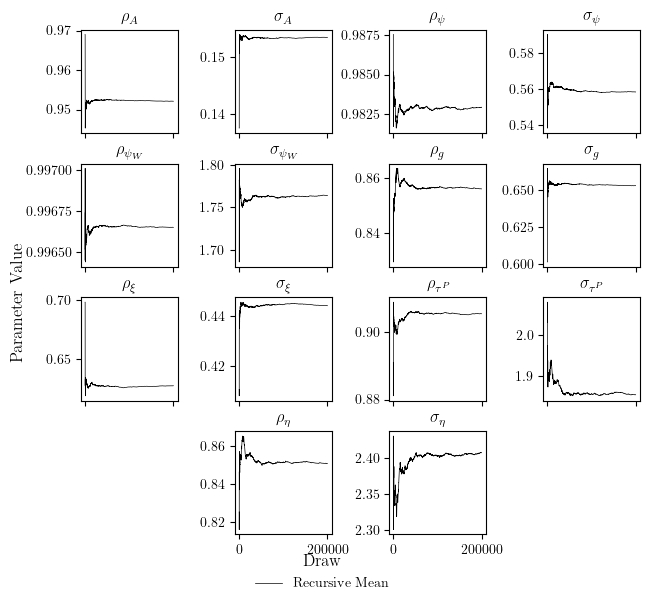

In [ ]:
# # setup plot
# fig, axs = plt.subplots(4, 4, sharex=True)
# fig.set_figwidth(6.5)
# fig.set_figheight(6)
# fig.supxlabel('Draw', y=1/20 * 8/7)
# fig.supylabel('Parameter Value')
# axs[-1, 0].set_axis_off()
# axs[-1, -1].set_axis_off()
# axs = np.delete(axs.ravel(), [12, 15])

# # plot them all
# shock_labels = ['A', r'\psi', r'{\psi_W}', 'g', r'\xi', r'{\tau^P}', r'\eta']
# for i in range(hank.N_z):
#     # plot rho
#     ax = axs[2 * i]
#     ax.set_title(rf'$\rho_{shock_labels[i]}$')
#     recursive_mean = sim_res[:, i].cumsum() / np.arange(1, 1 + sim_res.shape[0])
#     ax.plot(recursive_mean, 'k-', linewidth=0.5)

#     # plot sigma
#     ax = axs[2 * i + 1]
#     ax.set_title(rf'$\sigma_{shock_labels[i]}$')
#     recursive_mean = sim_res[:, hank.N_z + i].cumsum() / np.arange(1, 1 + sim_res.shape[0])
#     tln, = ax.plot(recursive_mean, 'k-', linewidth=0.5, label='Recursive Mean')

# ## make the figure
# fig.tight_layout(pad=0.5)
# fig.subplots_adjust(bottom=1/10 * 8/7)
# fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False, handles=[tln], ncols=2)
# fig.savefig('paper/figures/recursive_means.pdf')

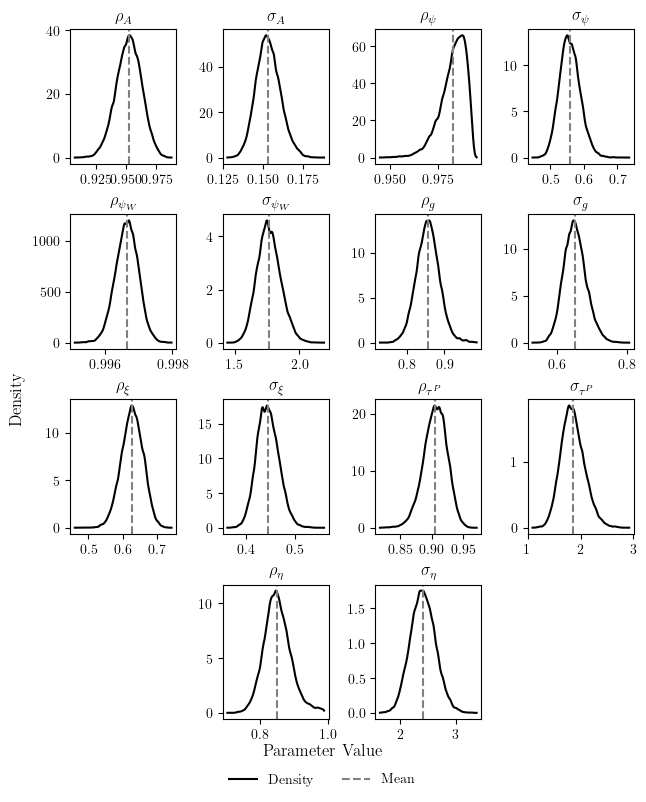

In [ ]:
# ## posteriors plot
# # setup plot
# fig, axs = plt.subplots(4, 4)
# fig.set_figwidth(6.5)
# fig.set_figheight(8)
# fig.supxlabel('Parameter Value', y=1/20)
# fig.supylabel('Density')
# axs[-1, 0].set_axis_off()
# axs[-1, -1].set_axis_off()
# axs = np.delete(axs.ravel(), [12, 15])

# # plot them all
# shock_labels = ['A', r'\psi', r'{\psi_W}', 'g', r'\xi', r'{\tau^P}', r'\eta']
# maxs = sim_res.max(axis=0)
# mins = sim_res.min(axis=0)
# for i in range(hank.N_z):
#     # plot rho
#     ax = axs[2 * i]
#     ax.set_title(rf'$\rho_{shock_labels[i]}$')
#     kde = gaussian_kde(sim_res[:, i])
#     x = np.linspace(mins[i], maxs[i], 250)
#     ax.plot(x, kde(x), c='k')

#     # means
#     ax.axvline(means[i], linestyle='--', color='gray')

#     # plot sigma
#     ax = axs[2 * i + 1]
#     ax.set_title(rf'$\sigma_{shock_labels[i]}$')
#     kde = gaussian_kde(sim_res[:, hank.N_z + i])
#     x = np.linspace(mins[hank.N_z + i], maxs[hank.N_z + i], 250)
#     dln, = ax.plot(x, kde(x), c='k', label='Density')

#     # means
#     mln = ax.axvline(means[hank.N_z + i], linestyle='--', color='gray', label='Mean')

# ## make the figure
# fig.tight_layout(pad=0.75)
# fig.subplots_adjust(bottom=1/10)
# fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False, handles=[dln, mln], ncols=2)
# fig.savefig('paper/figures/posteriors.pdf')

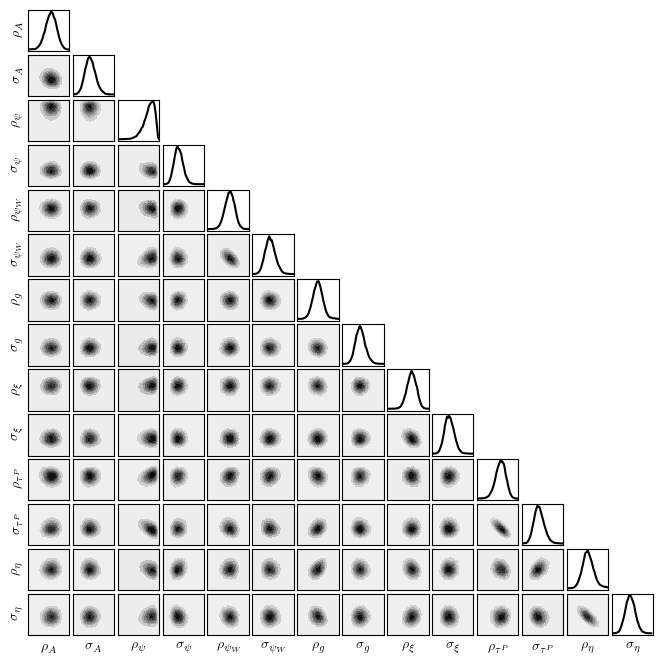

In [ ]:
# ## triangle plot
# # setup plot
# fig, axs = plt.subplots(2 * hank.N_z, 2 * hank.N_z, sharex='col')
# fig.set_figheight(6.5)
# fig.set_figwidth(6.5)
# for ax in axs[np.triu_indices(2 * hank.N_z, k=1)]:
#     ax.set_axis_off()

# # single variable things
# labels = [
#         r'$\rho_A$', r'$\sigma_A$', r'$\rho_\psi$', r'$\sigma_\psi$',
#         r'$\rho_{\psi_W}$', r'$\sigma_{\psi_W}$', r'$\rho_g$', r'$\sigma_g$',
#         r'$\rho_\xi$', r'$\sigma_\xi$', r'$\rho_{\tau^P}$', r'$\sigma_{\tau^P}$',
#         r'$\rho_\eta$', r'$\sigma_\eta$',
#     ]
# order = np.vstack((np.arange(hank.N_z), hank.N_z + np.arange(hank.N_z))).ravel('F')
# maxs = sim_res.max(axis=0)
# mins = sim_res.min(axis=0)
# for i, s in enumerate(order):
#     # formatting
#     axs[i, i].set_xticks([])
#     axs[i, i].set_yticks([])

#     # density plot
#     kde = gaussian_kde(sim_res[:, s])
#     x = np.linspace(mins[s], maxs[s], 250)
#     axs[i, i].plot(x, kde(x), c='k')

#     # axis labels
#     axs[-1, i].set_xlabel(labels[i])
#     axs[i, 0].set_ylabel(labels[i])

# # two variable things
# for i, s1 in enumerate(order):
#     for j, s2 in enumerate(order[:i]):
#         # formatting
#         axs[i, j].set_xticks([])
#         axs[i, j].set_yticks([])
#         axs[i, j].sharey(axs[i, 0])

#         # density
#         kde = gaussian_kde(sim_res.T[[s2, s1]])
#         x, y = np.meshgrid(np.linspace(mins[s2], maxs[s2], 100), np.linspace(mins[s1], maxs[s1], 100))
#         kdef = np.reshape(kde(np.vstack((x.ravel(), y.ravel()))), x.shape)
#         axs[i, j].contourf(x, y, kdef, cmap='binary')

# # final things
# fig.tight_layout(pad=0.25)
# fig.savefig('paper/figures/triangle.pdf')

In [23]:
## run instead of estiation, loads from file
res_df = pd.read_csv('data/bayes_results.csv', index_col=0)
shock_pars = res_df['mean'].to_dict()  # save the means to a dictaionary
rhos = {p.split('_')[1]: v for p, v in shock_pars.items() if p.startswith('rho')}
sigmas = {p.split('_')[1]: v for p, v in shock_pars.items() if p.startswith('sigma')}

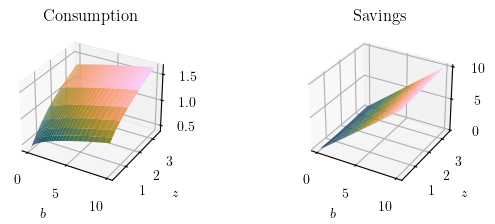

In [3]:
## plot setup
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection='3d'))
fig.set_figwidth(6.5)
fig.set_figheight(2.5)
for ax in axs:
    ax.set_xlabel('$b$')
    ax.set_ylabel('$z$')

## plot each thing
n = (hank.a_grid <= 10).sum()
axs[0].set_title('Consumption')
axs[0].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=hank.c[:n], cmap=cm.batlow)
axs[1].set_title('Savings')
axs[1].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=hank.a[:n], cmap=cm.batlow)

# final things
fig.tight_layout(pad=2.5)

In [13]:
## Areas of interest
wealth_percentiles = [0.5, 0.9, 0.99]
income_percentiles = [0.1, 0.5, 0.9]
pts_a = np.searchsorted(hank.dist.sum(axis=1).cumsum(), wealth_percentiles)  # points on the asset grid, 50th, 90th, 99th percentile
pts_z = np.searchsorted(hank.z_dist.cumsum(), income_percentiles)  # points on the productivity grid, 10th, 50th, 90th percentile
hank.z_grid[pts_z], hank.a_grid[pts_a]

# make info
hh_df = pd.DataFrame(
        np.array([
            np.repeat(hank.z_grid[pts_z], 3),
            np.tile(hank.a_grid[pts_a], (3, 1)).ravel(),
            hank.c[pts_a][:, pts_z].T.ravel(),
            # hank.l[pts_a][:, pts_z].T.ravel(),
            hank.a[pts_a][:, pts_z].T.ravel(),
        ]).T,
        columns=['z', 'wealth', 'c', 'a']
    )
hh_df['W'] = hh_df['z'] * hank.L * hank.W
hh_df['R'] = hh_df['wealth'] * hank.R
hh_df['T'] = hank.D + hank.eta
hh_df['tau'] = hank.tauL * hh_df['z']**hank.tauP
total_income = hh_df['W'] + hh_df['R'] + hh_df['T']
hh_df[['W', 'R', 'T', 'tau']] = hh_df[['W', 'R', 'T', 'tau']].div(total_income.values, axis=0) * 100

hh_df


,z,wealth,c,a,W,R,T,tau
0,0.443992,0.039830,0.506732,0.016053,53.215846,6.509369,40.274785,14.986261
1,0.443992,1.874048,0.696254,1.669921,13.311740,76.613677,10.074583,3.748756
2,0.443992,5.896041,0.896486,5.511791,5.034229,91.155770,3.810002,1.417703
3,1.000000,0.039830,0.754108,0.030414,71.925306,3.906206,24.168489,23.442635
4,1.000000,1.874048,0.897784,1.730127,25.698009,65.666893,8.635098,8.375759
5,1.000000,5.896041,1.078968,5.591045,10.666121,85.749827,3.584052,3.476412
6,2.252291,0.039830,1.111029,0.210516,85.229396,2.055125,12.715478,32.150411
7,2.252291,1.874048,1.200052,1.964882,43.787855,49.679381,6.532764,16.517746
8,2.252291,5.896041,1.351746,5.855292,21.192506,75.645758,3.161736,7.994282


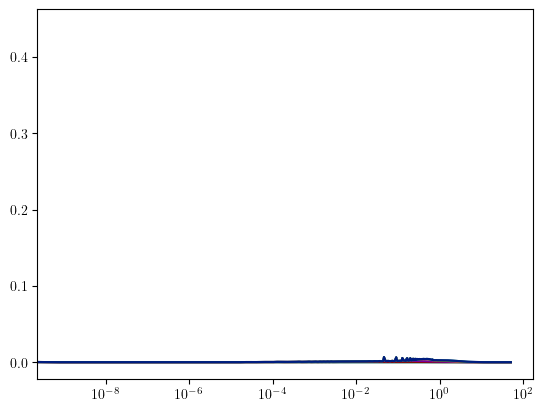

In [17]:
plt.xscale('log')
# plt.plot(hank.a_grid, hank.dist.sum(axis=-1).cumsum())
plt.plot(hank.a_grid, hank.dist.cumsum(axis=1))

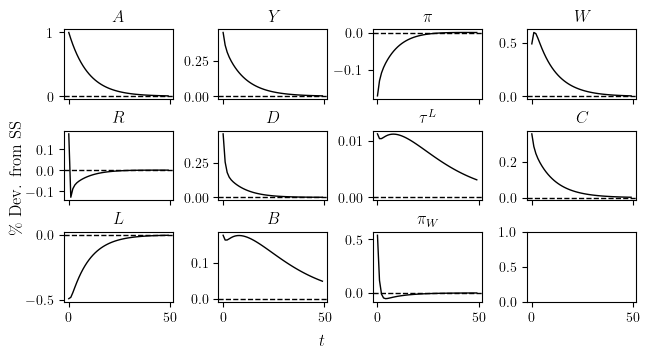

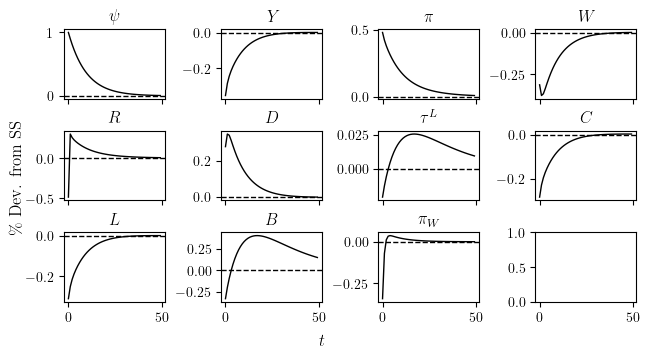

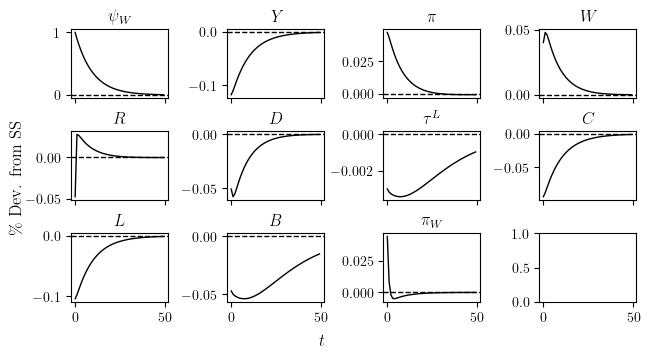

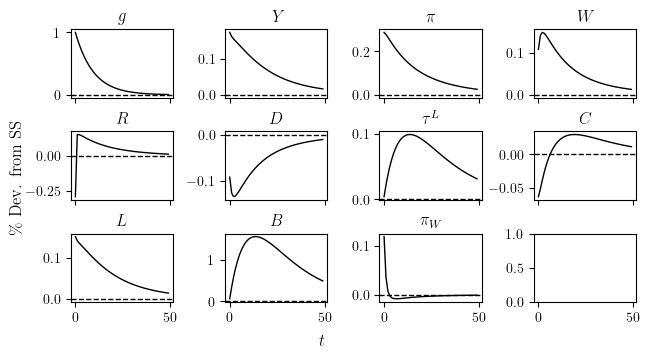

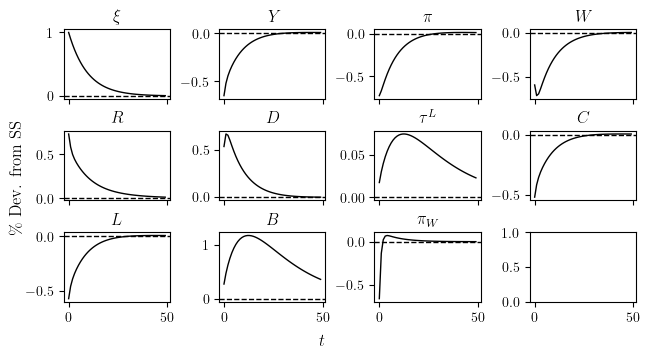

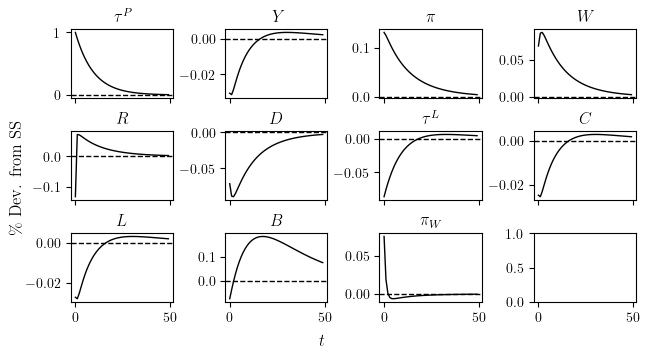

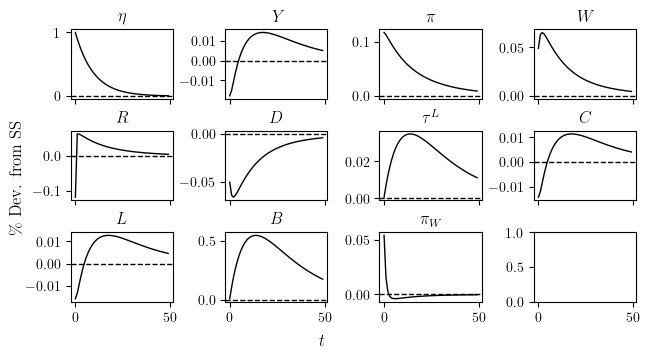

In [4]:
rhos = {s: 0.9 for s in hank.shocks}
sigmas = {s: 1 for s in hank.shocks}

tmax = 50
labels = {   # keys for labeling
        'epsA': '$A$', 'epspsi': r'$\psi$', 'epspsiW': r'$\psi_W$', 'epsg': '$g$', 'epsxi': r'$\xi$', 'epstauP': r'$\tau^P$', 'epseta': r'$\eta$',  # shocks
        'pi': r'$\pi$', 'W': '$W$', 'M': '$M$', 'D': '$D$', 'R': '$R$', 'I': '$I$', 'tauL': r'$\tau^L$',  # prices
        'curlC': '$C$', 'L': '$L$', 'curlB': '$B$',  # hh aggs
        'Y': '$Y$', 'N': '$N$', 'B': '$B$', 'G': '$G$',  # econ aggs
        'piW': r'$\pi_W$',
    }

for Z in hank.shocks:
    # solve irfs
    X_irfs, Z_irf = single_shock_irfs(G[Z], rhos[Z], T, sigma=sigmas[Z])

    # plot setup
    fig, axs = plt.subplots(3, 4, sharex=True)
    fig.set_figwidth(6.5)
    fig.set_figheight(3.5)
    fig.supxlabel('$t$')
    fig.supylabel(r'\% Dev. from SS')
    # axs[2, 0].set_axis_off()
    # axs[2, 3].set_axis_off()
    axs = axs.flatten()
    # axs = np.delete(axs.flatten(), [8, 11])
    outcomes = ['Y', 'pi', 'W', 'R', 'D', 'tauL', 'curlC', 'L', 'curlB', 'piW']

    # plot each irf
    axs[0].set_title(labels[Z])
    axs[0].plot(Z_irf[:tmax], '-k', linewidth=1)
    axs[0].axhline(0, c='k', ls='--', linewidth=1)
    for ax, X in zip(axs[1:], outcomes):
        ax.set_title(labels[X])
        ax.plot(X_irfs[X][:tmax], '-k', linewidth=1)
        ax.axhline(0, c='k', ls='--', linewidth=1)

    # final things
    fig.tight_layout(pad=0.5)
    # fig.savefig(f'paper/figures/{Z}_agg_irf.pgf')

In [30]:
## read data, creates in make_data.ipynb
df = pd.read_csv('data/data.csv')

# make it levels of model values
df['Y'] *= hank.Y
df['C'] *= hank.curlC
df['G'] *= hank.G
df['B'] *= hank.B
df['W'] *= hank.W
df['N'] *= hank.N
df['pi'] *= hank.pi
df['I'] *= hank.I

In [9]:
## Setup
outputs = np.array(['Y', 'pi', 'I', 'N', 'B', 'curlC', 'W'])  # outputs we estimate off of
est_outputs = np.where(outputs == 'curlC', 'C', outputs)  # rename 'curlC' to align with data df
priors = (
        [lambda x: log_beta(x, 0.5, 0.2) for _ in range(7)]  # ar1 coeffs
        + [lambda x: log_inv_gamma(x, 0.1, 2) for _ in range(7)]  # standard deviations
    )
est_G = estimation_G(G, outputs=outputs)  # make the G matric used in estimation, just concatenated version of G
drawf = gen_posterior_prob(est_G, df[np.where(outputs == 'curlC', 'C', outputs)].values, priors)  # evaluate log-liklihood

## posterior mode
res = posterior_mode(drawf, 7, X0=np.hstack((0.5 * np.ones(7), 0.1 * np.ones(7))), tol=1e-4)
assert res.success
mode = res.x  # get the mode values
invH = get_invhessian(drawf, mode)  # used to make draws in MCMC

NameError: name 'df' is not defined

In [8]:
rhos = {z: r for z, r in zip(hank.shocks, res.x[:7])}
sigmas = {z: s for z, s in zip(hank.shocks, res.x[7:])}

rhos, sigmas

NameError: name 'res' is not defined

In [31]:
est_G = estimation_G(hank.Gmat, outputs=['Y', 'pi', 'I', 'N', 'B', 'curlC', 'W'])
shock_paths, series_paths = historical_decomposition(est_G, np.array(list(rhos.values())), df[np.where(outputs == 'curlC', 'C', outputs)].values)

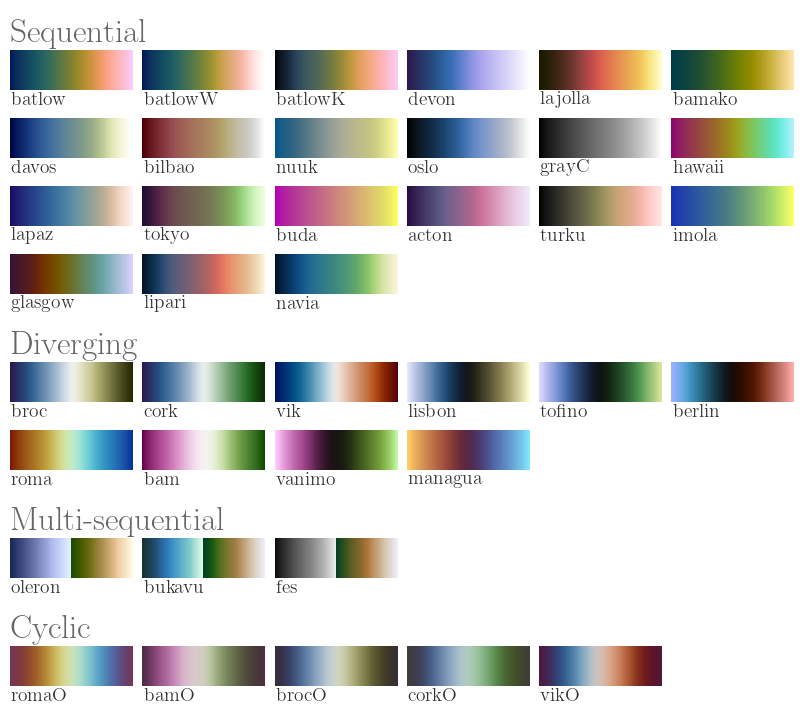

In [41]:
cmcrameri.show_cmaps()

In [44]:
sns.set_palette('cmc.hawaii')

'pi'

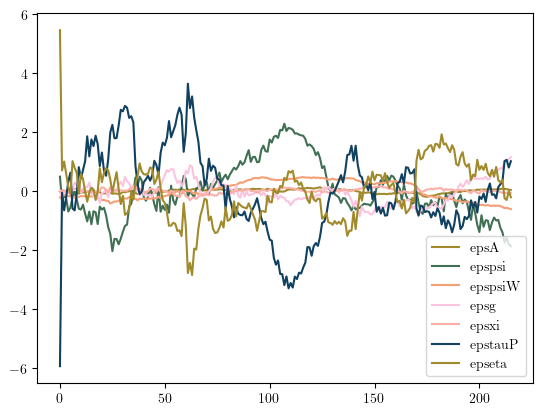

In [47]:
i = 1
# plt.set_cmap(cm.grayC)
# plt.set_cmap(cm.grayC)
sns.set_palette('cmc.batlowS')
# plt.set_cmap('cmc.batlowS')

plt.plot(series_paths[:, i].T, label=hank.shocks)
plt.legend()
outputs[i]

In [12]:
rhos = {z: r for z, r in zip(hank.shocks, )}
sigmas = {z: s for z, s in zip(hank.shocks, res.x[7:])}

rhos, sigmas

ValueError: not enough values to unpack (expected 2, got 1)

In [7]:
## get variaences
vars = all_shock_variences(all_shock_irfs(G, rhos, T, sigma=sigmas), h=4)
labels = {   # keys for labeling
        'epsA': 'TFP', 'epspsi': 'Markup', 'epspsiW': 'Wage Markup', 'epsg': 'Govt. Spending', 'epsxi': 'Mon. Pol.', 'epstauP': 'Tax Prog.', 'epseta': 'Transfers',  # shocks
        'pi': 'Inflation', 'W': 'Wages', 'M': '$M$', 'D': 'Dividends', 'R': 'Real Interest Rate', 'I': 'Interst Rate', 'tauL': 'Tax Level',  # prices
        'curlC': 'Consumption', 'L': 'Labor', 'curlB': 'Bonds',  # hh aggs
        'Y': 'Output', 'N': 'Labor', 'B': 'Bonds', 'G': 'Govt. Spending',  # econ aggs
    }

def plot_var_decomp(var, ax):
    # format graph
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])
    ax.set_xlim(0, 100)

    # varience decompoisiont
    shock_pct = np.array(list(var.values()))
    shock_pct = 100 * shock_pct / shock_pct.sum()
    shock_pct_start = shock_pct.cumsum() - shock_pct
    for i, s in enumerate(var.keys()):
        ax.barh('h', shock_pct[i], left=shock_pct_start[i], label=labels[s])

## make the plots
for outcomes, t in zip([['Y', 'pi'], ['W', 'R', 'D', 'tauL'], ['curlC', 'L', 'curlB']], ['agg', 'hh_dec', 'hh_agg']):
    fig, axs = plt.subplots(1, len(outcomes))
    fig.set_figwidth(6.5 / 4 * len(outcomes))
    fig.set_figheight(0.9)
    for i, X in enumerate(outcomes):
        axs[i].set_title(labels[X])
        plot_var_decomp(vars[X], axs[i])
    fig.tight_layout(pad=0.4)
    # fig.savefig('paper/figures/var_decomp_' + t + '.pgf')
fig.set_figheight(1.4)
fig.tight_layout(pad=0.4)
fig.subplots_adjust(bottom=4/7)
fig.legend(*axs[0].get_legend_handles_labels(), ncol=4, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
# fig.savefig('paper/figures/var_decomp_' + t + '.pgf')

NameError: name 'rhos' is not defined

In [19]:
sns.color_palette('Dark2', 7)

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

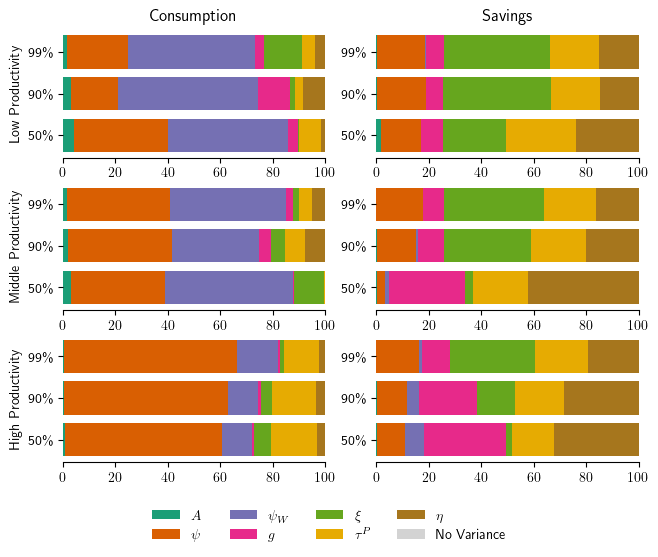

In [20]:
## get variences
vars = all_shock_variences(all_shock_irfs(G, rhos, T, sigma=sigmas, dxs=dxs), h=4)
pts_a = np.searchsorted(hank.dist.sum(axis=1).cumsum(), [0.5, 0.9, 0.99])  # points on the asset grid, 50th, 90th, 99th percentile
pts_z = np.searchsorted(hank.z_dist.cumsum(), [0.1, 0.5, 0.9])  # points on the productivity grid, 10th, 50th, 90th percentile
vars = {x: {Z: var[pts_a][:, pts_z].T for Z, var in vars[x].items()} for x in ['c', 'a']}
# vars[x][Z][i][j] points to effect of Z on x at income i at asset grid j
sns.set_palette(sns.color_palette('Dark2', 7))

## plot formatting
fig, axs = plt.subplots(3, 2)
fig.set_figwidth(6.5)
fig.set_figheight(5.5)

# titles
axs[0, 0].set_ylabel('Low Productivity')
axs[1, 0].set_ylabel('Middle Productivity')
axs[2, 0].set_ylabel('High Productivity')
axs[0, 0].set_title('Consumption')
axs[0, 1].set_title('Savings')

for i, x in enumerate(['c', 'a']):  # column, variable of interest
    # solve for varience
    var = np.array(list(vars[x].values()))  # get the variences into an array, use array operations to solve for percents
    total = var.sum(axis=0)
    total =  np.where(total != 0, total, 1)
    pct_var = 100 * var / total  # percent
    left_var = pct_var.cumsum(axis=0) - pct_var  # left side of bar

    for j in range(3):  # row, productivity level
        # formatting
        ax = axs[j, i]
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(0, 100)

        # plot each shock effect
        for k, s in enumerate(hank.shocks):
            ax.barh([r'50\%', r'90\%', r'99\%'], pct_var[k, j], left=left_var[k, j], label=labels[s])
        # gray bar (for no data)
        ax.barh([r'50\%', r'90\%', r'99\%'], 100, left=left_var[-1, j] + pct_var[-1, j], color='lightgray', label='No Variance')

# final things
fig.tight_layout(pad=0.4)
fig.subplots_adjust(bottom=1/6)
fig.legend(*ax.get_legend_handles_labels(), ncol=4, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
# fig.savefig('paper/figures/policy_var_decomp.pgf')

In [12]:
np.triu_indices(5, 1)

(array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3]), array([1, 2, 3, 4, 2, 3, 4, 3, 4, 4]))

In [13]:
## decompose the impulse response function
irf_decomp = decompose_all_irfs(G, hank.int_block_jacs, {Z: ar_shock_irf(rhos[Z], T, sigmas[Z]) for Z in G.keys()}, hank.shocks, dxs=dxs)

## setup
h = 4
pts_a = np.searchsorted(hank.dist.sum(axis=1).cumsum(), [0.5, 0.9, 0.99])  # points on the asset grid, 50th, 90th, 99th percentile
pts_z = np.searchsorted(hank.z_dist.cumsum(), [0.1, 0.5, 0.9])  # points on the productivity grid, 10th, 50th, 90th percentile
def get_var_covs(decomp_arr):
    # solve covs
    covs = (decomp_arr[None, :] * decomp_arr[:, None]).sum(axis=-1)  # get covariences between varibales
    if covs.sum() == 0:
        return np.zeros(covs.shape[0] * (covs.shape[1] + 1) // 2)
    covs = 100 * covs / covs.sum()  # normalize to 100

    # return
    i, j = np.triu_indices(covs.shape[0], 1)
    return np.hstack((np.diag(covs), covs[i, j]))

## lop over variables
for aggx, x in zip(['curlC', 'curlB'], ['c', 'a']):
    ## decompose irfs
    agg_decomp = {}
    policy_decomp = {}
    keys = {'L': 'L', 'W': 'W', 'R': 'R', 'D': 'T', 'epseta': 'T', 'epstauP': r'\tau', 'tauL': r'\tau'}
    for Z, Xirf in irf_decomp.items():
        ## agregates
        for X, irf in Xirf[aggx].items():
            if keys[X] in agg_decomp:
                agg_decomp[keys[X]] += irf[:4]
            else:
                agg_decomp[keys[X]] = 1 * irf[:4]
        
        ## households
        for X, irf in Xirf[x].items():
            if keys[X] in policy_decomp:
                policy_decomp[keys[X]] += irf[:h, pts_a][:, :, pts_z]
            else:
                policy_decomp[keys[X]] = 1 * irf[:h, pts_a][:, :, pts_z]

    ## arrays of decompositions (matrix multiplication is nice)
    agg_decomp_arr = np.array(list(agg_decomp.values()))
    policy_decomp_arr = np.array(list(policy_decomp.values()))

    ## make results dataframe
    factors = np.array(list(agg_decomp.keys()))
    i, j = np.triu_indices(len(factors), 1)
    res_df = pd.DataFrame(data=[np.hstack((factors, factors[i])), np.hstack((factors, factors[j]))], index=['V1', 'V2']).T
    res_df['agg'] = get_var_covs(agg_decomp_arr)
    for i in range(3):
        for j in range(3):
            res_df[f'{i}, {j}'] = get_var_covs(policy_decomp_arr[:, :, j, i])

    ## make the table
    table = r'''\resizebox{\textwidth}{!}{%
\begin{tabular}{lcccccccccc}
    \toprule
    & \textbf{Aggregate} & \multicolumn{3}{c}{\textbf{Low Productivity}} & \multicolumn{3}{c}{\textbf{Middle Productivity}} & \multicolumn{3}{c}{\textbf{High Productivity}} \\
    \cmidrule(lr){3-5} \cmidrule(lr){6-8} \cmidrule(lr){9-11}
    && 50th & 90th & 99th & 50th & 90th & 99th & 50th & 90th & 99th \\
    \midrule
    \textit{Variances} \\
'''
    for i in res_df[res_df['V1'] == res_df['V2']].index:
        table += '    \\quad $\\Var(' + res_df.loc[i, 'V1'] + ')$'
        for v in res_df.values[i, 2:].astype(float):
            table += f' & {v:,.1f}'
        table += ' \\\\\n'
    table += '    \\midrule\n    \\textit{Covariances} \\\\\n'
    for i in res_df[res_df['V1'] != res_df['V2']].index:
        table += '    \\quad $\\Cov(' + res_df.loc[i, 'V1'] + ', ' + res_df.loc[i, 'V2'] + ')$'
        for v in res_df.values[i, 2:].astype(float):
            table += f' & {v:,.1f}'
        table += ' \\\\\n'
    table += '    \\bottomrule \n    \\multicolumn{11}{c}{\\parbox{\\textwidth}{\\vspace{1ex} \\scriptsize \\textit{Notes:} Forecast error variance decomposition calculated at a 4 quarter time horizon with total variance normalized to 100\\%. Percentiles correspond to the 50th, 90th, and 99th wealth percentiles.}}\n\\end{tabular}%\n}'

    print(f'{aggx}, {x}:')
    print(table)

curlC, c:
\resizebox{\textwidth}{!}{%
\begin{tabular}{lcccccccccc}
    \toprule
    & \textbf{Aggregate} & \multicolumn{3}{c}{\textbf{Low Productivity}} & \multicolumn{3}{c}{\textbf{Middle Productivity}} & \multicolumn{3}{c}{\textbf{High Productivity}} \\
    \cmidrule(lr){3-5} \cmidrule(lr){6-8} \cmidrule(lr){9-11}
    && 50th & 90th & 99th & 50th & 90th & 99th & 50th & 90th & 99th \\
    \midrule
    \textit{Variances} \\
    \quad $\Var(L)$ & 79.3 & 1,390.4 & 146.5 & 211.4 & 91.0 & 35.5 & 66.8 & 16.8 & 17.6 & 26.3 \\
    \quad $\Var(W)$ & 0.0 & 12.4 & 1.0 & 10.2 & 0.4 & 0.4 & 2.7 & 0.1 & 0.4 & 1.0 \\
    \quad $\Var(R)$ & 29.1 & 114.1 & 116.5 & 117.2 & 34.4 & 43.1 & 29.6 & 28.0 & 26.9 & 17.8 \\
    \quad $\Var(T)$ & 14.2 & 731.4 & 99.9 & 183.5 & 11.8 & 9.8 & 25.0 & 1.9 & 2.6 & 4.6 \\
    \quad $\Var(\tau)$ & 0.4 & 737.5 & 13.6 & 4.4 & 2.0 & 0.1 & 0.4 & 2.7 & 2.8 & 3.9 \\
    \midrule
    \textit{Covariances} \\
    \quad $\Cov(L, W)$ & 0.9 & -123.8 & 11.5 & 46.1 & -6.1 & 3.6 & 13.5 

In [14]:
i, j = np.tril_indices(len(factors), 1)
factors[i]

array(['L', 'L', 'W', 'W', 'W', 'R', 'R', 'R', 'R', 'T', 'T', 'T', 'T',
       'T', '\\tau', '\\tau', '\\tau', '\\tau', '\\tau'], dtype='<U4')

In [15]:
## make results dataframe
factors = np.array(list(agg_decomp.keys()))
i, j = np.triu_indices(len(factors), 1)
res_df = pd.DataFrame(data=[np.hstack((factors, factors[i])), np.hstack((factors, factors[j]))], index=['V1', 'V2']).T
res_df['agg'] = get_var_covs(agg_decomp_arr)
for i in range(3):
    for j in range(3):
        res_df[f'{i}, {j}'] = get_var_covs(policy_decomp_arr[:, :, j, i])

res_df

,V1,V2,agg,"0, 0","0, 1","0, 2","1, 0","1, 1","1, 2","2, 0","2, 1","2, 2"
0,L,L,29.851582,1.751211,0.027412,0.003123,14.234821,0.866104,0.103888,11604.631952,17.327460,1.857700
1,W,W,1.837965,0.563838,0.063887,0.028487,0.976103,0.277079,0.079581,957.731960,1.971483,0.282486
2,R,R,250.586414,49.313141,90.561132,96.787510,114.144729,97.452806,98.630372,35659.470017,191.959904,117.891291
3,T,T,0.161505,7.809431,0.106153,0.023851,2.647449,0.117265,0.033672,179.069766,0.418743,0.064816
4,\tau,\tau,4.136879,4.911518,0.696048,0.133820,3.112589,0.549497,0.101860,8862.239498,12.690335,1.389472
5,L,W,-6.842816,0.948589,-0.005814,0.005717,0.650025,-0.357054,-0.072680,-2591.085345,-4.862588,-0.624972
6,L,R,-81.690069,-7.499754,0.340482,0.463419,-38.942489,-4.168899,-0.686075,-20198.363125,-39.080764,-5.952361
7,L,T,0.184697,-3.657418,-0.045390,-0.008192,-5.367123,0.036606,0.030276,743.803761,1.850418,0.266368
8,L,\tau,10.810364,-2.704007,-0.095046,0.005433,-6.647038,-0.688955,-0.102459,9819.330795,14.331378,1.549712
9,W,R,21.212147,-3.510991,1.882644,0.989055,0.711176,4.375193,1.851218,4929.360265,17.545156,4.193673


In [16]:
hank.curlC

0.7989999999999947

In [17]:
res_df


,V1,V2,agg,"0, 0","0, 1","0, 2","1, 0","1, 1","1, 2","2, 0","2, 1","2, 2"
0,L,L,29.851582,1.751211,0.027412,0.003123,14.234821,0.866104,0.103888,11604.631952,17.327460,1.857700
1,W,W,1.837965,0.563838,0.063887,0.028487,0.976103,0.277079,0.079581,957.731960,1.971483,0.282486
2,R,R,250.586414,49.313141,90.561132,96.787510,114.144729,97.452806,98.630372,35659.470017,191.959904,117.891291
3,T,T,0.161505,7.809431,0.106153,0.023851,2.647449,0.117265,0.033672,179.069766,0.418743,0.064816
4,\tau,\tau,4.136879,4.911518,0.696048,0.133820,3.112589,0.549497,0.101860,8862.239498,12.690335,1.389472
5,L,W,-6.842816,0.948589,-0.005814,0.005717,0.650025,-0.357054,-0.072680,-2591.085345,-4.862588,-0.624972
6,L,R,-81.690069,-7.499754,0.340482,0.463419,-38.942489,-4.168899,-0.686075,-20198.363125,-39.080764,-5.952361
7,L,T,0.184697,-3.657418,-0.045390,-0.008192,-5.367123,0.036606,0.030276,743.803761,1.850418,0.266368
8,L,\tau,10.810364,-2.704007,-0.095046,0.005433,-6.647038,-0.688955,-0.102459,9819.330795,14.331378,1.549712
9,W,R,21.212147,-3.510991,1.882644,0.989055,0.711176,4.375193,1.851218,4929.360265,17.545156,4.193673


<Axes: ylabel='Density'>

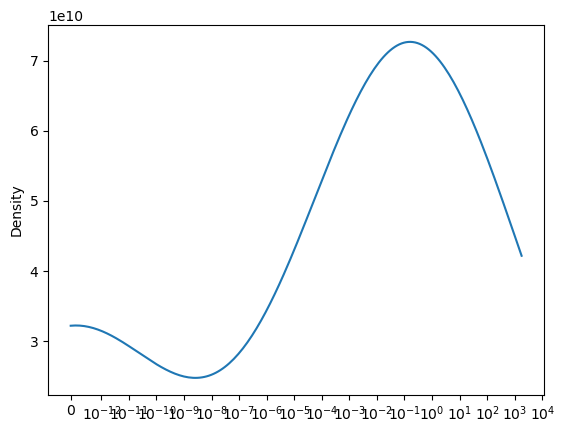

In [18]:
plt.xscale('symlog', linthresh=1e-12)
sns.kdeplot(x=hank.a_grid, weights=np.maximum(hank.dist.sum(axis=1), 0), clip=[0, 10])

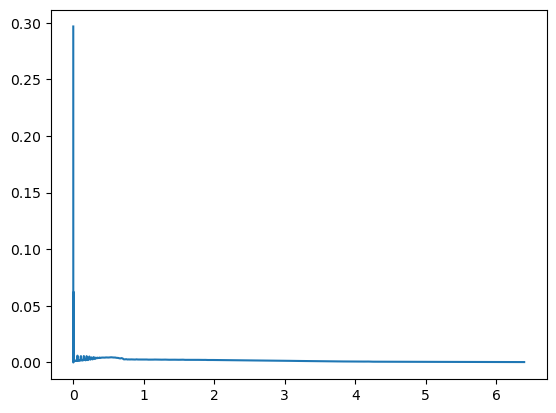

In [19]:
n = 300
plt.plot(hank.a_grid[:n], hank.dist.sum(axis=1)[:n])